In [1]:
import os.path as P
import pickle
import typing as T

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, Ridge
from sklearn.metrics import PredictionErrorDisplay, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor

In [2]:
random_state = 42


# Model Selection

In the last notebook we proceeded to create our preprocessing pipeline and export it to a reusable artifact object. Now it's time to use or transformed features to deep dive into the Machine Learning part, by training a bunch of regression models, check their performance and select some of them to be used for our future final model.


## Using our preprocessing pipeline

Let's retrieve our preprocessing pipeline.


In [3]:
artifacts_root_dir = P.join(P.dirname(P.abspath("")), "artifacts")


In [4]:
preprocessing_pipeline_path = P.join(
    artifacts_root_dir, "preprocessing_pipeline.pickle"
)

with open(preprocessing_pipeline_path, "rb") as f:
    preprocessing_pipeline = pickle.load(f)

preprocessing_pipeline


Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value=0.0),
                                                  ['condominium_fee', 'suites',
                                                   'parking_spots', 'bedrooms',
                                                   'bathrooms']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(),
                                                  ['annual_iptu_tax',
                                                   'usable_area'])],
                                   verbose_feature_names_out=False)),
                ('featureunion-1',
                 FeatureUnion(t...
                ('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7fe0ae549fc0>)),
                ('columntransformer-2',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['property_type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['usable_area',
                                                   'neighborhood_general_tax_score'])],
                                   verbose_feature_names_out=False))])

In [5]:
target_transform_path = P.join(artifacts_root_dir, "target_transform.pickle")

with open(target_transform_path, "rb") as f:
    target_transform = pickle.load(f)

target_transform


FunctionTransformer(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>)

Note that this time we didn't even needed to use the [cloudpickle](https://github.com/cloudpipe/cloudpickle) package: pickle can deserialize the artifact right away.


## Don't Forget to Configure the Sklearn API

We **must** execute the following line


In [6]:
sklearn.set_config(transform_output="pandas")


## Load and Transform Data

With our transforms loaded, we can proceed to load and process the dataset.


In [7]:
preprocessed_dataset_root_dir = P.join(P.dirname(P.abspath("")), "data", "processed")


In [8]:
df_file = P.join(preprocessed_dataset_root_dir, "cleaned_sp_sales_data.parquet")

features = pd.read_parquet(df_file)
target = features.pop("sale_price")

display(features)
display(target)


,index,neighborhood,property_type,usable_area,bathrooms,suites,bedrooms,parking_spots,ad_date,condominium_fee,annual_iptu_tax
0,1,Vila Santa Teresa (Zona Sul),House,129.0,2.0,1.0,3.0,2.0,2016-03-21,NaN,NaN
1,2,Vila Olimpia,Apartament,80.0,2.0,1.0,3.0,2.0,2018-10-26,686.0,1610.0
2,3,Pinheiros,Apartament,94.0,1.0,0.0,3.0,2.0,2018-05-29,1120.0,489.0
3,4,Vila Santa Clara,Condominium,110.0,1.0,1.0,3.0,2.0,2018-04-16,0.0,0.0
4,5,Aclimacao,Apartament,141.0,4.0,3.0,4.0,2.0,2019-01-09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
82072,88742,Vila Carmosina,Apartament,48.0,1.0,0.0,2.0,1.0,2017-10-07,244.0,0.0
82073,88743,Bela Vista,Apartament,60.0,1.0,NaN,1.0,1.0,2017-12-13,273.0,86.0
82074,88744,Liberdade,Apartament,53.0,2.0,1.0,2.0,1.0,2018-11-28,210.0,0.0
82075,88745,Vila Lageado,Apartament,20.0,3.0,2.0,3.0,2.0,2019-02-06,NaN,NaN


0         336000
1         739643
2         630700
3         385000
4        1106000
          ...   
82072     171150
82073     251999
82074     249782
82075     623000
82076    1820000
Name: sale_price, Length: 82077, dtype: int64

In [9]:
transformed_features = preprocessing_pipeline.transform(features)
transformed_target = target_transform.transform(target)

display(transformed_features)
display(transformed_target)


,property_type_Apartament,property_type_Condominium,property_type_Flat,property_type_House,property_type_Penthouse,property_type_Two-story House,usable_area,neighborhood_general_tax_score,suites,parking_spots,bedrooms,bathrooms,index,has_suites,has_parking_spots,has_bedrooms,has_bathrooms,n_features
0,0.0,0.0,0.0,1.0,0.0,0.0,0.311599,-0.208425,0.250000,0.50,0.666667,0.2,0.000000,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,-0.462635,0.947172,0.250000,0.50,0.666667,0.2,0.000011,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,-0.241425,0.575735,0.000000,0.50,0.666667,0.0,0.000023,0.0,1.0,0.0,0.0,0.5
3,0.0,1.0,0.0,0.0,0.0,0.0,0.011386,-0.332291,0.250000,0.50,0.666667,0.0,0.000034,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.501207,0.477077,0.750000,0.50,1.000000,0.6,0.000045,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82072,1.0,0.0,0.0,0.0,0.0,0.0,-0.968257,-0.343076,0.000000,0.25,0.333333,0.0,0.999955,0.0,1.0,0.0,0.0,0.5
82073,1.0,0.0,0.0,0.0,0.0,0.0,-0.778649,-0.170300,0.260507,0.25,0.000000,0.0,0.999966,1.0,1.0,0.0,0.0,1.0
82074,1.0,0.0,0.0,0.0,0.0,0.0,-0.889253,-0.192438,0.250000,0.25,0.333333,0.2,0.999977,1.0,1.0,0.0,0.0,1.0
82075,1.0,0.0,0.0,0.0,0.0,0.0,-1.410676,-0.184797,0.500000,0.50,0.666667,0.4,0.999989,1.0,1.0,0.0,0.0,1.0


0        12.724866
1        13.513923
2        13.354586
3        12.860999
4        13.916260
           ...    
82072    12.050296
82073    12.437180
82074    12.428344
82075    13.342302
82076    14.414347
Name: sale_price, Length: 82077, dtype: float64

We are now prepared to train some models.


# Model Selection

We'll follow a straighforward approach.

1. Split the data into train and test sets.
2. Define de regression models we want to use.
3. Evaluate each model using cross-validation with the train set.
4. Select the top-k best models.
5. Check the models performance graphically.
6. Train a model composed of the selected models.
7. Evaluate the final model using the train and test sets.


## Data Split

We'll randomly separate 20% of the dataset rows to be used as test set. The remaining rows will compose the train set.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    transformed_features,
    transformed_target,
    test_size=0.2,
    shuffle=True,
    random_state=random_state,
)

print([set.shape for set in [X_train, y_train, X_test, y_test]])

[(65661, 18), (65661,), (16416, 18), (16416,)]


## Model Definitions

We'll evaluate the following regression models:

- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
- [Bayesian](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [Extra Trees Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://lightgbm.readthedocs.io/en/stable/)
- [CatBoost Regressor](https://catboost.ai/)

We'll create a function that evaluates the avarage cross-validation Mean Squared Logarithmic Error (MSLE) for each model using the train set.


In [11]:
# Yes, I really like type hints.
class Predictor(T.Protocol):
    def fit(self, X: T.Any, y: T.Any, *args, **kwargs) -> None:
        raise NotImplementedError

    def predict(self, X: T.Any) -> T.Any:
        raise NotImplementedError

In [12]:
def evaluate_models(
    X: pd.DataFrame, y: pd.Series, test_models: T.Iterable[T.Tuple[str, Predictor]]
) -> pd.DataFrame:
    results = []
    for model_name, model in test_models:
        scorer = make_scorer(mean_squared_error)

        scorer = cross_val_score(model, X, y, cv=5, scoring=scorer)
        avg_msle = scorer.mean()

        results.append({"Model": model_name, "Avg MSLE": avg_msle})

    results_df = pd.DataFrame(results).sort_values(by="Avg MSLE").reset_index(drop=True)

    return results_df

Let's run it


In [13]:
results = evaluate_models(
    X_train,
    y_train,
    test_models=tuple(
        (model.__class__.__name__, model)
        for model in (
            Ridge(),
            Lasso(),
            ElasticNet(),
            BayesianRidge(),
            RandomForestRegressor(),
            ExtraTreesRegressor(),
            XGBRegressor(),
            LGBMRegressor(),
            CatBoostRegressor(allow_writing_files=False, silent=True),
        )
    ),
)
results

,Model,Avg MSLE
0,XGBRegressor,0.045479
1,CatBoostRegressor,0.046054
2,RandomForestRegressor,0.050285
3,LGBMRegressor,0.051432
4,ExtraTreesRegressor,0.060862
5,Ridge,0.134550
6,BayesianRidge,0.134550
7,Lasso,0.385755
8,ElasticNet,0.385755


The winners are, unsurprisingly, some of the community's most beloved Machine Learning algorithms in recent years: **CatBoost**, **XGBoost**, **Random Forest** and **LightGBM**. All of them are based on the war horse of Machine Learning: Decision Trees.


## Visual Performance Evaluation

In this section we'll graphically evaluate the performance of the top-4 models with lowest average MSLE (the best performers). We'll plot two graphs, both based on prediction error:

- **Actual values $\times$ Predicted Values**: a scatter plot where the predicted values in the x-axis and the actual values in the y-axis. The dotted diagonal line represents the behavior of a **perfect regressor**: more closer the points are to the line, more accurate the model will be.
- **Residual $\times$ Predicted values:** a scatter plot where the the the predicted values are in the x-axis and the residuals of the predictions are in the y-axis. The dotted horizontal line represents the behavior of a **perfect regressor**. This plot shows how the residuals are vary.


In [14]:
def graphical_evaluation(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    test_models: T.Iterable[T.Tuple[str, Predictor]],
) -> None:
    for model_name, model in test_models:
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)
        msle = mean_squared_error(y_test, predictions)

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

        PredictionErrorDisplay.from_predictions(
            predictions, y_test, kind="actual_vs_predicted", ax=ax1
        )
        PredictionErrorDisplay.from_predictions(
            predictions, y_test, kind="residual_vs_predicted", ax=ax2
        )

        fig.suptitle(f"{model_name} (MSLE {(msle):0.4f})")

        plt.show()

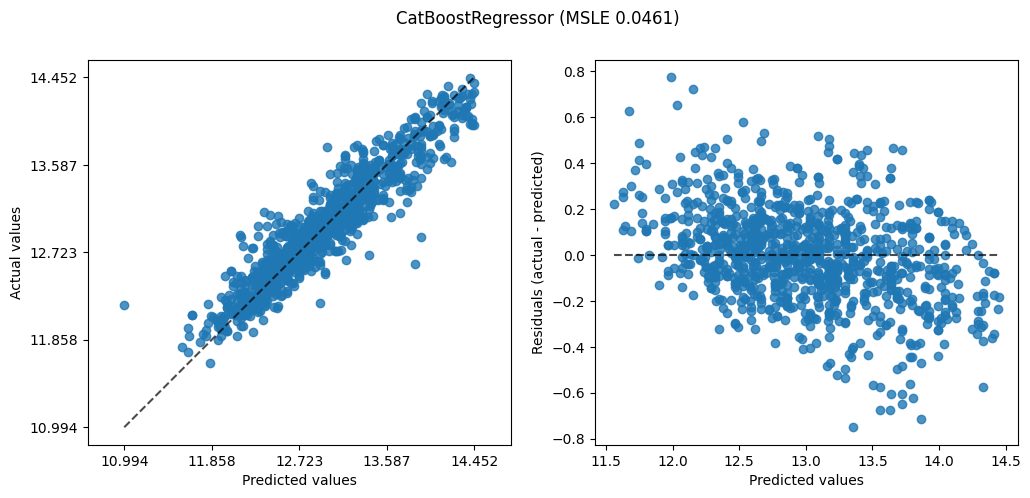

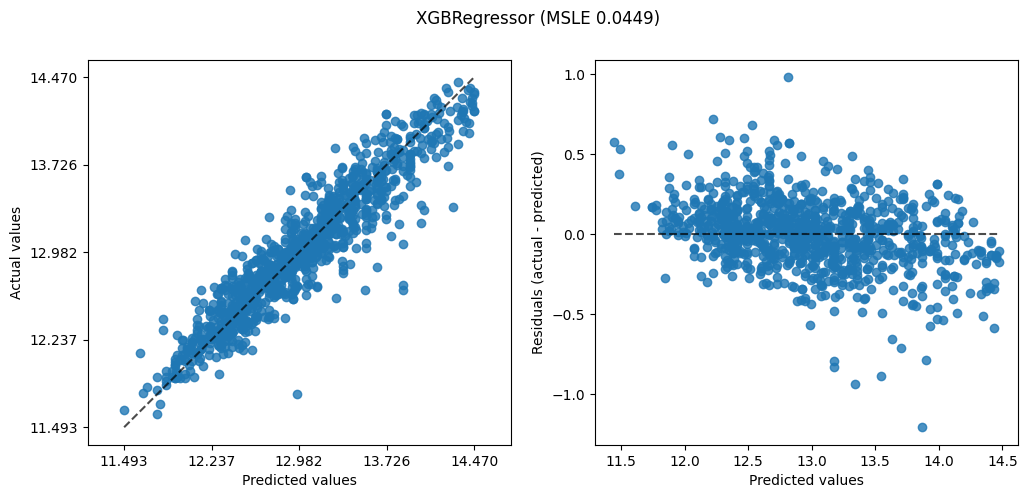

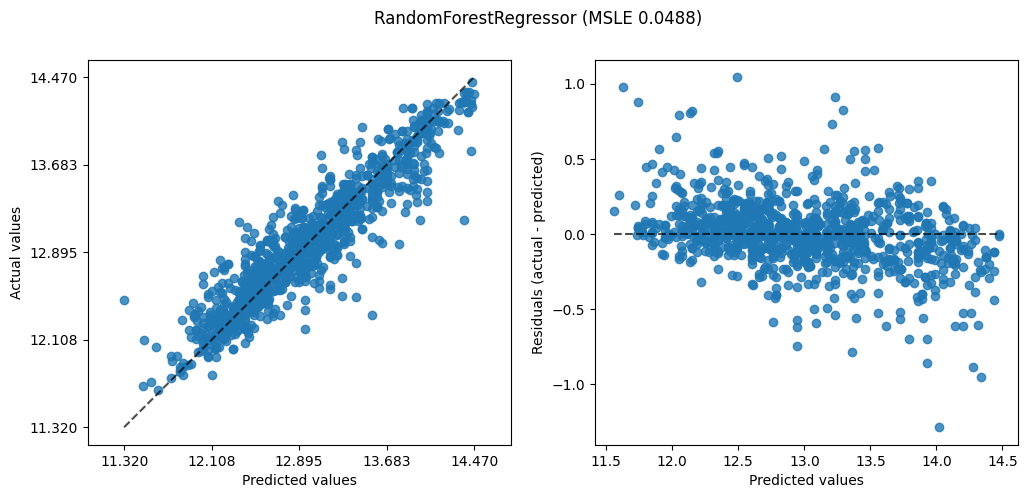

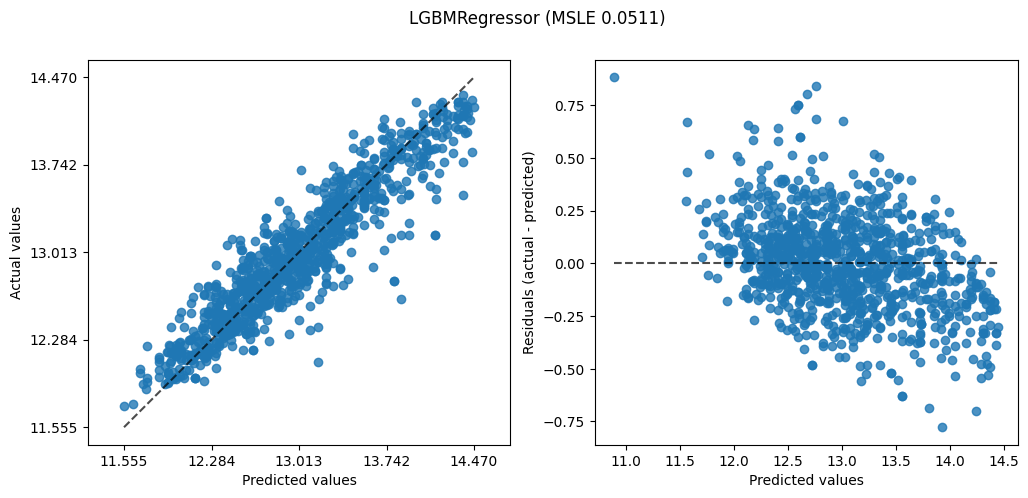

In [15]:
graphical_evaluation(
    X_train,
    y_train,
    X_test,
    y_test,
    [
        (model.__class__.__name__, model)
        for model in (
            CatBoostRegressor(
                allow_writing_files=False, silent=True, random_seed=random_state
            ),
            XGBRegressor(random_state=random_state),
            RandomForestRegressor(random_state=random_state),
            LGBMRegressor(random_state=random_state),
        )
    ],
)

You must me wandering: how do I interpret these plots? Well, this is actually pretty easy.

In the left plot each figure, if our predictions are good, we expect to see the "cloud" of point concentrated around the dotted diagonal line. Each of our models does this well, indicating their efficiency.

The right plot is a bit more insteresting. Ideally, we don't want to see the "clouds" forming any curved shapes, which would indicate that model cannot stasifactorly handle some **non-linearities** in the data. Fortunatelly, we don't see any "curves" in our   "clouds", indicating that the models do pretty well.

The interesting point to note how the clouds are concentrated. For example, the residuals of both **CatBoost** model (the first and best model) and the **LGBMRegressor** (the least and worst performing model) have almost the same range of values (from -1.0 to 0.76). What makes them different is how their point clouds are concentrated. We can clearly see that the LGBMRegressor have a more dispersed cloud compared with CatBoost.

These differences indicates that each models behave diffently for each data sample. We'll exploit this to build a better model

## Voting Regressor

We have 4 different Machine Learning regressors that satisfacorly makes good predictions of house prices, but behave differently on each dataset sample. Well now build a model that leverages these different responses to create better predictions. This kind of model is called an [Ensenble Method](https://scikit-learn.org/stable/modules/ensemble.html#ensemble-methods). Ensenble methods can be classified in two families:
- In **averaging methods**, we build each model independently and average their predictions. This reduce the **variance** of the resulting prediction,making the combined estimator usally better than any of the individual estimators.
- In **boosting methods**, each estimator is build sequentialy, one upon the other. The motivations to combine several weak models to produce a powerful model.

Here, we'll use the [Voting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html), an **averaging method** that builds it's predictions by taking an **weightened average** of the composing models' predictions.

In [16]:
voting_regressor = VotingRegressor(
    estimators=[
        (model.__class__.__name__, model)
        for model in (
            CatBoostRegressor(
                allow_writing_files=False, silent=True, random_seed=random_state
            ),
            XGBRegressor(random_state=random_state),
            RandomForestRegressor(random_state=random_state),
            LGBMRegressor(random_state=random_state),
        )
    ],
    n_jobs=-1
)

Now we'll fit it to the train set. Note that each estimator will be fitted in parallel (the `n_jobs` parameter instructs the sklearn API to use all processors to this)

In [17]:
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('CatBoostRegressor',
                             <catboost.core.CatBoostRegressor object at 0x7fe0ac2074c0>),
                            ('XGBRegressor',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_i...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...)),
                            ('RandomForestRegressor',
                             RandomForestRegressor(random_state=42)),
                            ('LGBMRegressor', LGBMRegressor(random_state=42))],
                n_jobs=-1)

We'll check it's performance using the test set. Let's compute the MSLE and plot the same errors plots as before.

In [18]:
predictions = voting_regressor.predict(X_test)

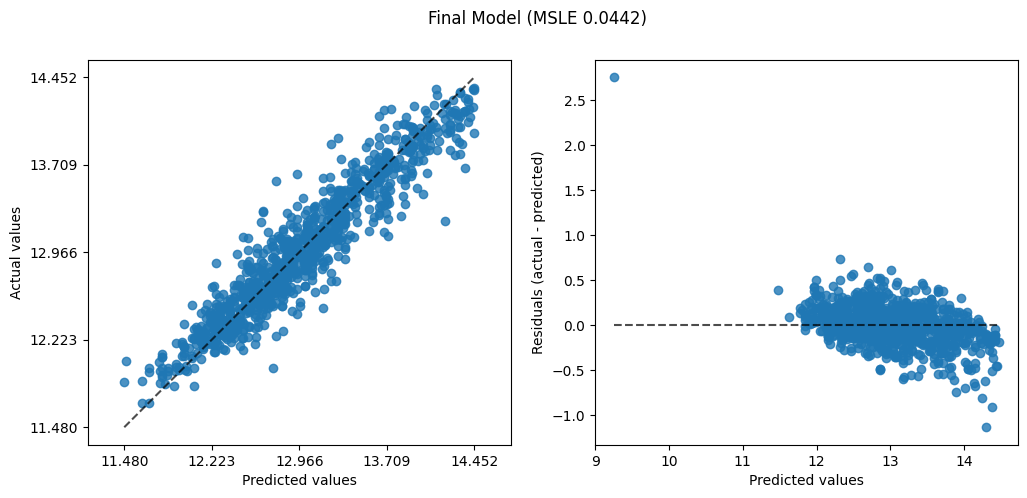

In [19]:
msle = mean_squared_error(y_test, predictions)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

PredictionErrorDisplay.from_predictions(
    predictions, y_test, kind="actual_vs_predicted", ax=ax1
)
PredictionErrorDisplay.from_predictions(
    predictions, y_test, kind="residual_vs_predicted", ax=ax2
)

fig.suptitle(f"Final Model (MSLE {(msle):0.4f})")

plt.show()

Although by a little bit, our model performer better than any of the individual models.

Now lt's take a better look at the general behavior of the error.

### Error Analysis

Let's begin by checking the distribution of the general error. First, we train our model using the whole dataset, get the predictions for the dataset and get their respective values back to the original target feature space

In [20]:
voting_regressor.fit(transformed_features, transformed_target)

all_predictions = voting_regressor.predict(transformed_features)
transformed_predictions = target_transform.inverse_transform(all_predictions)
transformed_predictions

array([ 390900.13582528,  687648.51944519,  667739.72650086, ...,
        320567.38608754,  558553.56552625, 1592241.90556727])

In [21]:
errors = pd.DataFrame()

errors["property_type"] = features["property_type"]
errors["price"] = target
errors["error"] = target - transformed_predictions

errors.describe().round()

,price,error
count,82077.0,82077.0
mean,539484.0,13977.0
std,368268.0,110563.0
min,10500.0,-641104.0
25%,276500.0,-37459.0
50%,420000.0,-367.0
75%,665000.0,47094.0
max,1931999.0,1413826.0


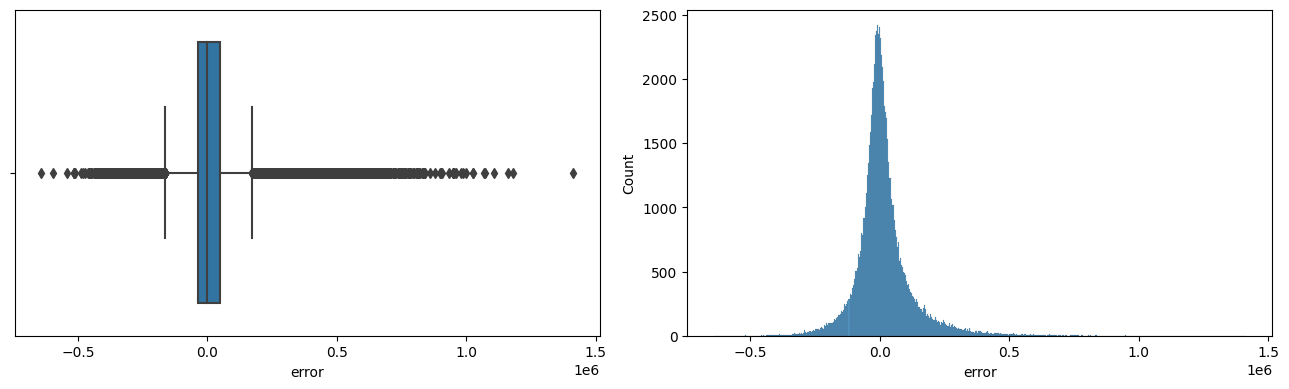

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4))

sns.boxplot(x="error", data=errors, ax=ax1)
sns.histplot(x="error", data=errors, ax=ax2)

plt.tight_layout();

At first, we can see that the majority of the errors are, approximatelly, between -R$37000,00 and R$45000,00. The real problem is the ouliers, that  get in a magitude of R$1500000,00 of difference with the real price.

Now we'll check how's the errors for each property type.

### Error Analysis by Property Type

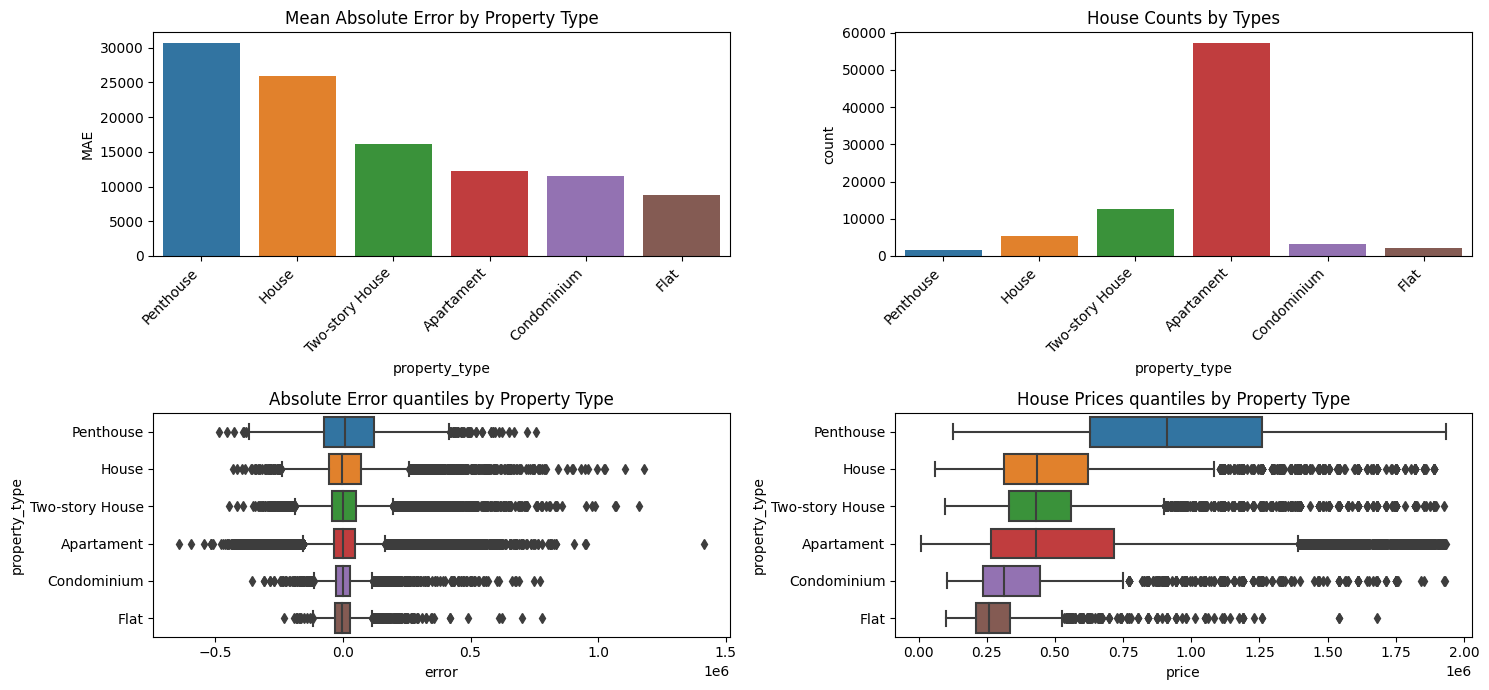

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15, 7))

maes = (
    errors.groupby("property_type")
    .agg(MAE=("error", np.average))
    .sort_values("MAE", ascending=False)
)
sns.barplot(x=maes.index, y="MAE", data=maes, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_title("Mean Absolute Error by Property Type")

sns.countplot(x="property_type", data=errors, order=maes.index, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
ax2.set_title("House Counts by Types")

sns.boxplot(x="error", y="property_type", data=errors, order=maes.index, ax=ax3)
ax3.set_title("Absolute Error quantiles by Property Type")

sns.boxplot(x="price", y="property_type", data=errors, order=maes.index, ax=ax4)
ax4.set_title("House Prices quantiles by Property Type")

plt.tight_layout()

Few points here:
- The three house types with higher average error are: the **residential buildings**, **penthouses'** and **houses**.
- Of those three types, **houses** have the higher error variation, while **residential buildings** have the lowest variation.
- **Residential buildings** and **penthouses** also have the higher price variations in the dataset.
- **Residential buildings** and **penthouses** also are two of the three least numerous property types in dataset.
- The top-3 most numerous types also have the highest price variations: **apertament**, **two-story houses** and **houses**.
- The **apartment** errors must be amplifying the regression errors due to it's volumnetry (almost twice than **two-story house**).

In the next notebook we'll improve our model by choosing the best hyperparameters for each one.